In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
from mini_yolov3.model import MiniYoloV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.evals import calculate_mAP
from torchvision.ops import box_iou
from tqdm import tqdm

In [23]:
train_dataset = SVHNDataset(split="train")
# train_dataset = Subset(train_dataset, range(12, 13))
train_dataset = Subset(train_dataset, range(0, 2))

In [24]:
train_dataset[0]["bbox"]

tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])

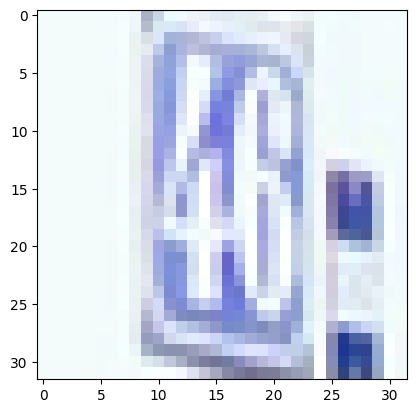

In [25]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

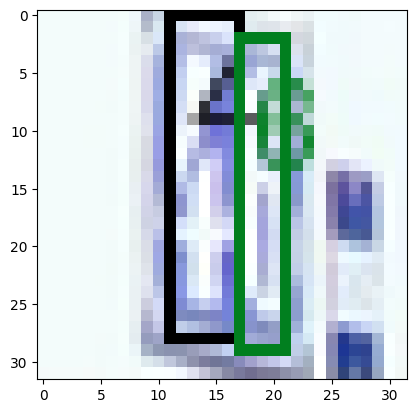

In [26]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [27]:
dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)

In [28]:
len(dataloader)

1

In [29]:
for batch in dataloader:
    print(batch["bboxes"])
    print(box_convert(batch["bboxes"][0], "xywh", "cxcywh"))
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3443, 0.1290, 0.1967, 0.7419],
        [0.5082, 0.1613, 0.1639, 0.7419]]), tensor([[0.3551, 0.0217, 0.1963, 0.8696],
        [0.5327, 0.0652, 0.1495, 0.8696]])]
tensor([[0.4426, 0.5000, 0.1967, 0.7419],
        [0.5902, 0.5323, 0.1639, 0.7419]])


NameError: name 'anchors' is not defined

In [30]:
batch["images"].shape

torch.Size([2, 3, 32, 32])

In [31]:
import json

In [34]:
torch.manual_seed(0)

config = json.load(open("./configs/experiment.json", "r"))
model = MiniYoloV3(**config)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=250,
    lr=3e-3,
    batch_size=64,
    lambda_coord=0.05,
    lambda_conf=1.0,
    lambda_cls=0.5,
    device="cpu",
    eval_every=100000,
)

100%|██████████| 250/250 [00:37<00:00,  6.60it/s, class_loss=0.00202, conf_loss=0.00743, coord_loss=5.61e-6, loss=0.00946]


[3.0341224670410156,
 2.627716064453125,
 2.4313161373138428,
 2.3099913597106934,
 2.192189931869507,
 2.1175901889801025,
 2.035177707672119,
 1.9565584659576416,
 1.8849225044250488,
 1.8181885480880737,
 1.7539080381393433,
 1.6904325485229492,
 1.6175620555877686,
 1.5395015478134155,
 1.458115577697754,
 1.3853180408477783,
 1.3225994110107422,
 1.2664278745651245,
 1.2144463062286377,
 1.1656688451766968,
 1.1193848848342896,
 1.0746665000915527,
 1.0313712358474731,
 0.9896274209022522,
 0.9493676424026489,
 0.9104199409484863,
 0.8730162382125854,
 0.8373173475265503,
 0.8022511005401611,
 0.7688409090042114,
 0.7366065979003906,
 0.7055004239082336,
 0.6754875779151917,
 0.6464528441429138,
 0.6183043718338013,
 0.5910999178886414,
 0.5649488568305969,
 0.5397700071334839,
 0.5155220627784729,
 0.4921817183494568,
 0.4698314666748047,
 0.4485046863555908,
 0.4281432032585144,
 0.40875282883644104,
 0.3902958333492279,
 0.37269067764282227,
 0.3559592664241791,
 0.339896827936

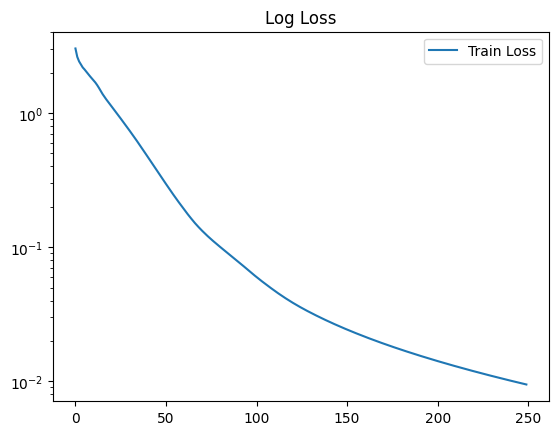

In [35]:
trainer.train()

In [36]:
pred = model(batch["images"])
pred.shape

torch.Size([2, 4, 4, 30])

In [37]:
pred[0, 0, 0, :], pred[0, 1, 1, :]

(tensor([ 0.0332,  0.1958, -0.1447,  0.6250, -4.9104, -0.2206,  0.3163,  0.0558,
          0.3104, -0.4824, -0.2723, -0.6049,  0.3513,  0.2464,  0.0387, -0.6716,
          0.8534, -0.2136,  0.5676, -5.2365, -0.4234, -1.1441, -0.6169, -0.0828,
          0.8048, -0.6598, -0.4961,  0.5092,  0.1806, -0.1639],
        grad_fn=<SliceBackward0>),
 tensor([-0.5065, -0.7817,  0.2088,  0.1485, -4.6454, -0.2028, -0.4158,  0.2839,
          0.1545, -0.5851, -0.1555, -0.2461,  0.1260,  0.2443,  0.2147, -0.8175,
          0.2232,  0.7791, -0.0826, -4.0628, -0.9305, -0.4984, -0.3817, -0.2219,
         -0.1559, -0.2829, -0.6201,  0.7194, -0.1781, -0.4752],
        grad_fn=<SliceBackward0>))

In [42]:
i = 0

In [43]:
output = model.inference(
    batch["images"],
)

bounding_boxes = output.bboxes
bounding_boxes

[{'bboxes': tensor([[0.5902, 0.5318, 0.1640, 0.7411],
          [0.4427, 0.5000, 0.1970, 0.7403]]),
  'confidence': tensor([0.9965, 0.9958]),
  'labels': tensor([1, 7]),
  'scores': tensor([0.9998, 0.9996])},
 {'bboxes': tensor([[0.6073, 0.5000, 0.1494, 0.8715],
          [0.4533, 0.4564, 0.1961, 0.8707]]),
  'confidence': tensor([0.9932, 0.9898]),
  'labels': tensor([6, 4]),
  'scores': tensor([0.9996, 0.9996])}]

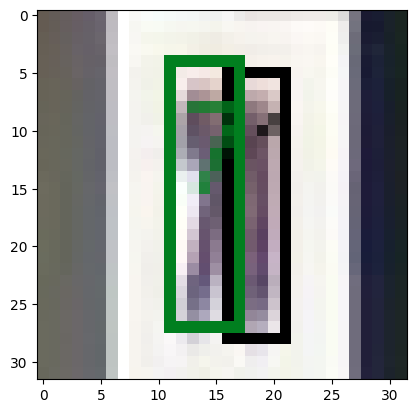

In [44]:
plt.imshow(
    draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
)
)

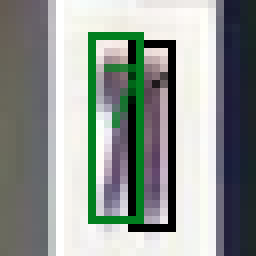

In [45]:
draw_bounding_boxes(batch["images"][i],
                        box_convert(
                            bounding_boxes[i]["bboxes"], 
                            "cxcywh",
                            "xyxy"
                        ), 
                        bounding_boxes[i]["labels"]
).resize((256, 256), 0)

In [83]:
calculate_mAP(
    model,
    trainer.train_loader,
)

100%|██████████| 1/1 [00:00<00:00, 52.11it/s]


{'map': 1.0,
 'map_50': 1.0,
 'map_75': 1.0,
 'map_small': 1.0,
 'map_medium': -1.0,
 'map_large': -1.0,
 'mar_1': 1.0,
 'mar_10': 1.0,
 'mar_100': 1.0,
 'mar_small': 1.0,
 'mar_medium': -1.0,
 'mar_large': -1.0,
 'map_per_class': -1.0,
 'mar_100_per_class': -1.0,
 'classes': [1, 4, 6, 7]}